####  Here is demonstrarion of several pipelines to preproccess images, get embeddings from the model and build [AnnoyIndex](https://github.com/spotify/annoy) 

In [1]:
!nvidia-smi

Sat Apr 28 18:41:21 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.94                 Driver Version: 384.94                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8    N/A /  N/A |     77MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import sys
import os

import cv2 as cv
from imageio import imsave, imread, imwrite
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

# sys.path.append('..')
from model import MyModel
from dataset import B,V,F, FilesIndex, Dataset, Pipeline, action, inbatch_parallel
from face_batch import CelebrityBatch, load_func

In [3]:
model_path = 'model/'
model_name = 'model-20170512-110547'
checkpoint_path = 'model-20170512-110547.ckpt-250000'
src_images = '../img_align_celeba/img_align_celeba/'
IMG_SHAPE = (160, 160)


#### Data preproccessing pipeline:
For face detection we use haaracasades from opencv

In [4]:
preprocess_ppl = (Pipeline()
     .load(src=src_images, fmt='image', components='images')
     .to_cv(src='images')
#      .to_rgb()
     .detect_face()
     .crop_from_bbox()
     .resize(IMG_SHAPE, fmt='cv')
     .to_rgb()
    )

#### To get embeddings we load pre-trained [facenet](https://github.com/davidsandberg/facenet) model

In [5]:
init_model_ppl = (Pipeline()
                    .init_model('static', MyModel, model_name,
                                config={'load' : {'path' : model_path, 'graph': model_name + '.meta',
                                                  'checkpoint' : checkpoint_path}, 
                                        'build': False}))

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from model/model-20170512-110547.ckpt-250000


In [6]:
predict_ppl = ((preprocess_ppl + init_model_ppl)
                .init_variable('predicted_embeddings', init_on_each_run=0)
                .init_variable('indices', init_on_each_run=0)
                .predict_model(model_name, fetches="embeddings:0",
                               feed_dict={'input:0' : B('images'), 'phase_train:0' : False},
                               save_to=B('embedding'), mode='w')
                .dump(dst='demo_embeddings.csv', fmt='csv', mode='a', components='embedding', header=False)
              )

To run pipeline we create instance of Dataset class which supports indexing over the data:

In [7]:
fileindex = FilesIndex(path=src_images+'*.jpg', no_ext=True)
dset = Dataset(fileindex, batch_class=CelebrityBatch)

And here we will run only several iterations: 

In [8]:
NUM_ITERS = 1
BATCH_SIZE = 5

In [9]:
for i in tqn(range(NUM_ITERS)):
    btch = (predict_ppl << dset).next_batch(BATCH_SIZE, n_epochs=1, shuffle=False, drop_last=True)

To create an Index we load saved embeddings and build Spotify's Annoy Index (for now)

In [252]:
fileindex = FilesIndex(path= '../img_align_celeba/cropped_photos/'+'*.jpg', no_ext=True)
dset = Dataset(fileindex, batch_class=CelebrityBatch)

In [253]:
build_index_ppl = (Pipeline()
                     .load(src='data/cropped_embeddings.csv', fmt='csv', components=['embedding'], dtype=str,
                           index_col='file_name', post=load_func)
                     .build_index('150k_index')
                     .dump(dst='int_indices_mapping.csv', fmt='csv', mode='a', components='int_indices', header=False)
                  ) << dset

In [18]:
tmp = build_index_ppl.next_batch(157220, n_epochs=1, shuffle=False, drop_last=True)

saved Index to path 150k_index


Now when we have built and saved Index to 150k_index.ann we can load use it to find nearest neighbours for new images:

In [57]:
import cv2 as cv

In [11]:
# We use new photos from test dataset
# src_images = 'test_photos/'
src_images = 'test_photos/' 
#open cv wants a path with slashes!

fileindex = FilesIndex(path= src_images+'*.jpg', no_ext=True)

test_set = Dataset(fileindex, batch_class=CelebrityBatch)

In [12]:
test_set.indices

array(['000009', '000052', '000053', '000054', '000055', '000057',
       '000058', '000059', '000061', '000062', '000063', '000064',
       '000065', '000066', '000069', '000071', '000072', '000073',
       '000075', '000076', '000077', '1', '10', '2', '9',
       'ee72093c-3c01-433a-8d25-701cca06c975'], dtype='<U52')

In [18]:
search_celebs_ppl = predict_ppl.find_nearest_neighbours(k_neighbours=50) << test_set

In [19]:
btch = search_celebs_ppl.next_batch(10, n_epochs=None)

In [20]:
import pandas as pd
data = pd.read_csv('int_indices_mapping.csv', names=['file_name', 'int_index'], index_col='int_index')

In [21]:
data.loc[13, 'file_name']

100009

original


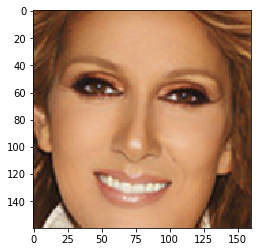

neighbour 105410
neighbour 101089
neighbour 101946
neighbour 10277
neighbour 107613
neighbour 105242
neighbour 104723


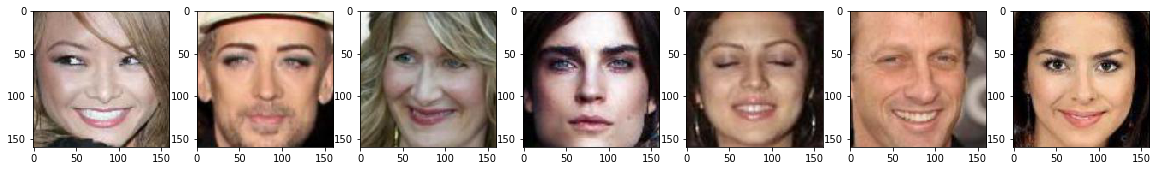

original


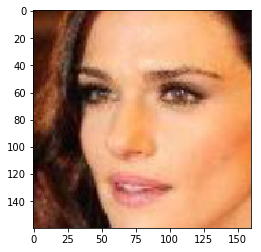

neighbour 106673
neighbour 108478
neighbour 101349
neighbour 107662
neighbour 101989
neighbour 105341
neighbour 107464


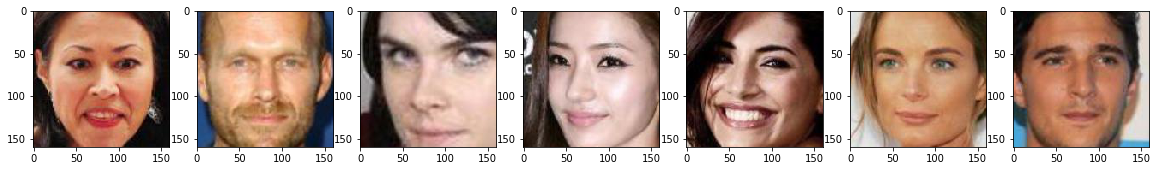

original


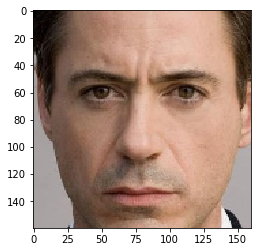

neighbour 104960
neighbour 102913
neighbour 104083
neighbour 107624
neighbour 108707
neighbour 103598
neighbour 10368


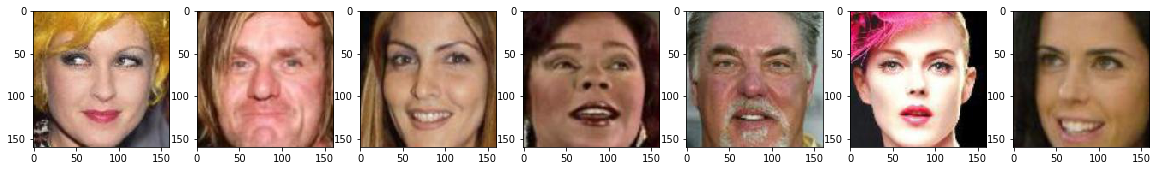

original


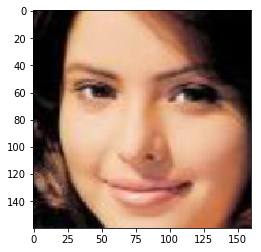

neighbour 102069
neighbour 109985
neighbour 10904
neighbour 105194
neighbour 102572
neighbour 100694
neighbour 102622


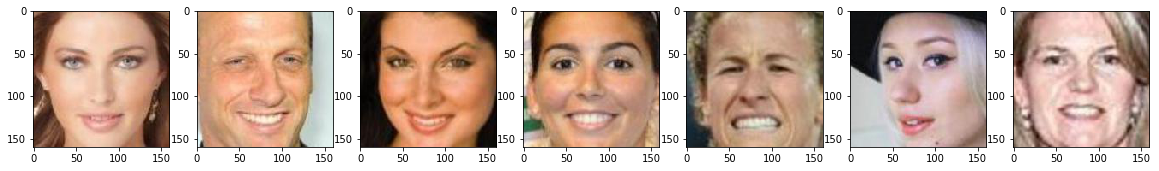

original


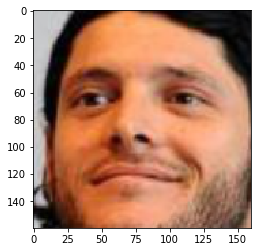

neighbour 105567
neighbour 107694
neighbour 10196
neighbour 106062
neighbour 107467
neighbour 107835
neighbour 103246


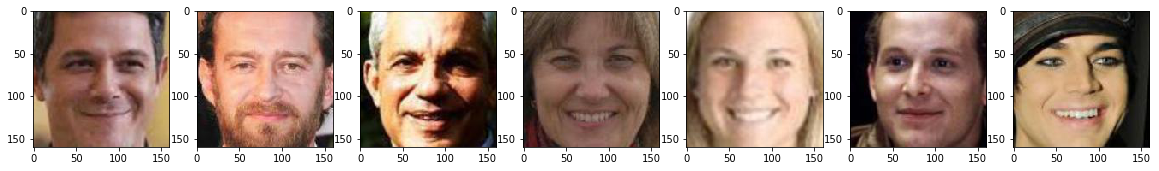

original


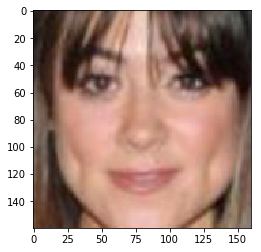

neighbour 105569
neighbour 109129
neighbour 109020
neighbour 101962
neighbour 105756
neighbour 110055
neighbour 105311


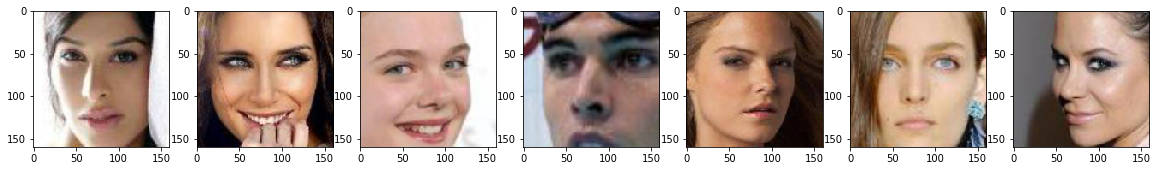

original


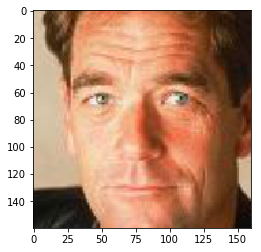

neighbour 10720
neighbour 107189
neighbour 108079
neighbour 10317
neighbour 100046
neighbour 109013
neighbour 109714


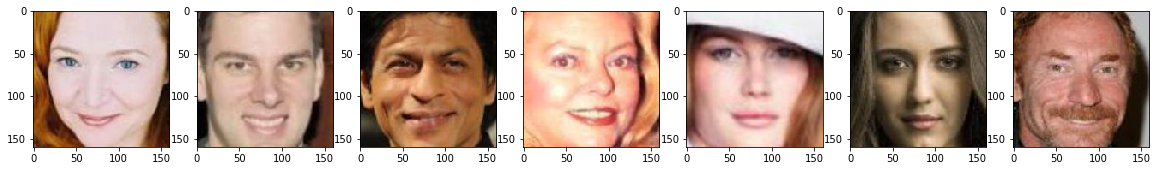

original


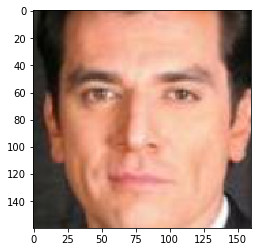

neighbour 107185
neighbour 10759
neighbour 105996
neighbour 109013
neighbour 100938
neighbour 104377
neighbour 10155


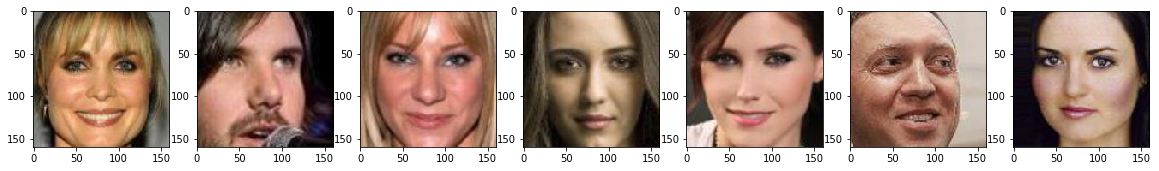

original


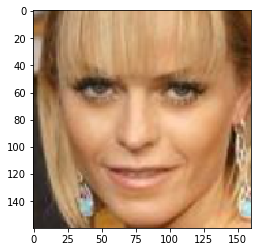

neighbour 10337
neighbour 107860
neighbour 109494
neighbour 10764
neighbour 104390
neighbour 104065
neighbour 106317


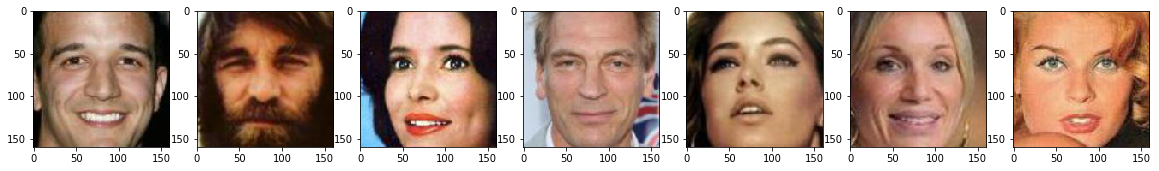

original


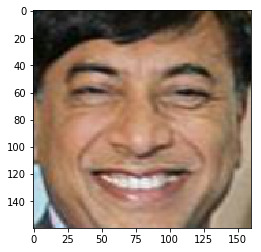

neighbour 108105
neighbour 103589
neighbour 109589
neighbour 105039
neighbour 108109
neighbour 109236
neighbour 102754


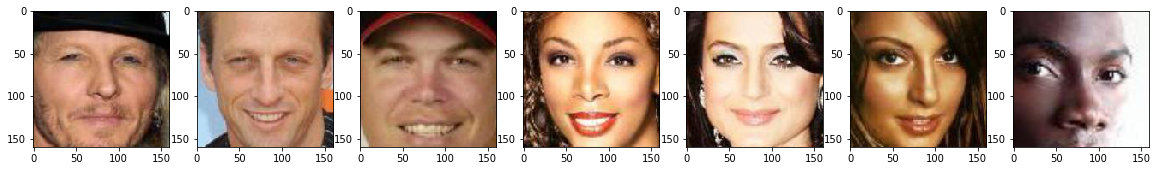

In [17]:
for j in range(len(btch.indices)):
    print('original')
    pic = btch.images[j]
    plt.imshow(pic)
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20, 120))
    for i, neighbour_index in enumerate(btch.neighbours[j][:7]):
        file_name = data.loc[neighbour_index, 'file_name']
        print('neighbour', file_name)
        pic = imread('../img_align_celeba/cropped_photos/' + str(file_name) + '.jpg')
        ax[i].imshow(pic)
    plt.show()

original


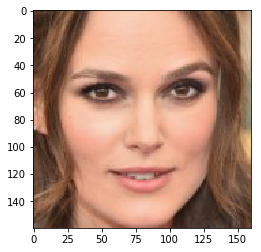

neighbour 101265
neighbour 106961
neighbour 109144
neighbour 105655
neighbour 109782
neighbour 101275
neighbour 109252


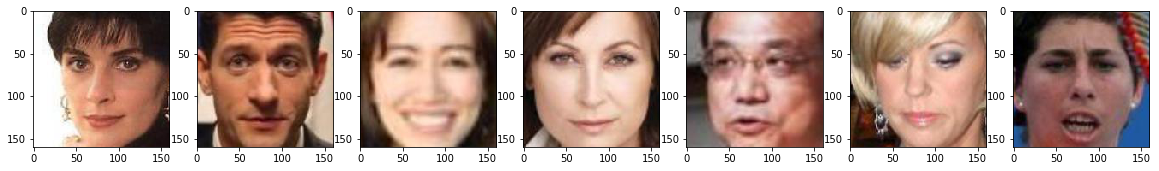

In [222]:
for j in range(len(btch.indices)):
    print('original')
    pic = btch.images[j]
    plt.imshow(pic)
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(20, 120))
    for i, neighbour_index in enumerate(btch.neighbours[j][:7]):
        file_name = data.loc[neighbour_index, 'file_name']
        print('neighbour', file_name)
        pic = imread('../img_align_celeba/cropped_photos/' + str(file_name) + '.jpg')
        ax[i].imshow(pic)
    plt.show()